Shape of the dataset: (9471, 15)

Preview of the data:
         Date      Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  \
0  10/03/2004  18.00.00    2,6       1360.0     150.0     11,9         1046.0   
1  10/03/2004  19.00.00      2       1292.0     112.0      9,4          955.0   
2  10/03/2004  20.00.00    2,2       1402.0      88.0      9,0          939.0   
3  10/03/2004  21.00.00    2,2       1376.0      80.0      9,2          948.0   
4  10/03/2004  22.00.00    1,6       1272.0      51.0      6,5          836.0   

   NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH  \
0    166.0        1056.0    113.0        1692.0       1268.0  13,6  48,9   
1    103.0        1174.0     92.0        1559.0        972.0  13,3  47,7   
2    131.0        1140.0    114.0        1555.0       1074.0  11,9  54,0   
3    172.0        1092.0    122.0        1584.0       1203.0  11,0  60,0   
4    131.0        1205.0    116.0        1490.0       1110.0  11,2  59,6   

 

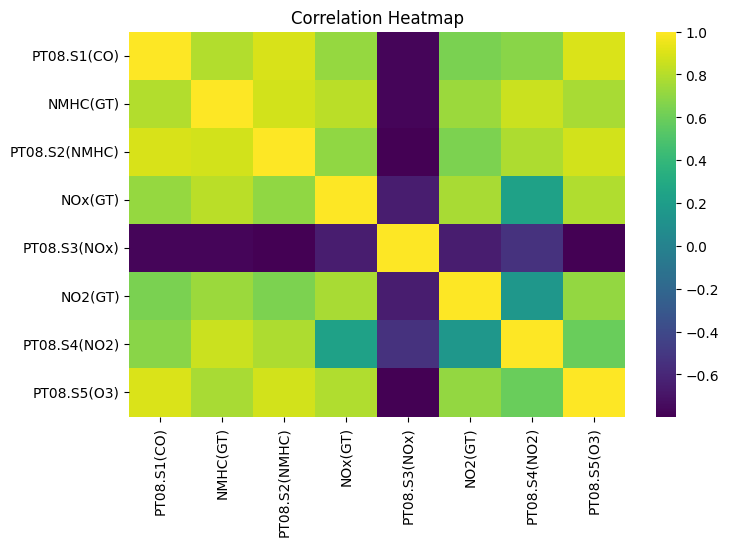

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# loading the dataset
df = pd.read_csv("AirQualityUCI.csv", sep=';')

# the file has an empty last column, so I'll drop columns that are completely blank
df = df.dropna(axis=1, how='all')

# having a quick look at the structure
print("Shape of the dataset:", df.shape)
print("\nPreview of the data:")
print(df.head())

# checking the data types to see which columns are numeric and which are not
print("\nData types:")
print(df.dtypes)

# replacing the placeholder -200 with NaN since that actually means missing values
df = df.replace(-200, np.nan)

# checking for the missing values after cleaning
print("\nMissing values per column:")
print(df.isna().sum())

# looking at the basic statistical summaries
print("\nSummary statistics:")
print(df.describe(include='all'))

# checking the correlations between numerical features
plt.figure(figsize=(8,5))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# dropping the any fully empty columns
df = df.dropna(axis=1, how='all')

# listing the columns that use comma instead of dot
comma_cols = ["CO(GT)", "C6H6(GT)", "T", "RH", "AH"]

# converting the comma decimals to float
for col in comma_cols:
    df[col] = df[col].str.replace(",", ".", regex=False).astype(float)

# converting the Date and Time into a single datetime column
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H.%M.%S")

# dropping the original Date and Time columns
df = df.drop(columns=["Date", "Time"])

# replacing the placeholder -200 (still possible) with NaN
df = df.replace(-200, np.nan)

# selecting the target
target_col = "CO(GT)"

# removing the rows where target is missing
df = df[df[target_col].notna()]

# checking how many missing values remain
print("Missing values after removing target NaN:")
print(df.isna().sum())

# filling the remaining NaNs with median of each column
df = df.fillna(df.median(numeric_only=True))

# selecting the numerical features only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# removing the target from feature list
numeric_cols = [col for col in numeric_cols if col != target_col]


Missing values after removing target NaN:
CO(GT)              0
PT08.S1(CO)       330
NMHC(GT)         6784
C6H6(GT)          330
PT08.S2(NMHC)     330
NOx(GT)           413
PT08.S3(NOx)      330
NO2(GT)           416
PT08.S4(NO2)      330
PT08.S5(O3)       330
T                 330
RH                330
AH                330
datetime            0
dtype: int64


In [6]:

# building the X and y
X = df[numeric_cols].values
y = df[target_col].values

# scaling the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# splitting it into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print("Final shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Final shapes:
X_train: (6139, 12)
X_test: (1535, 12)
y_train: (6139,)
y_test: (1535,)


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# building a simple baseline neural network
model = Sequential()

# input layer + first hidden layer
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))

# second hidden layer
model.add(Dense(32, activation='relu'))

# output layer for regression
model.add(Dense(1))

# compiling the model
# using Adam because it's generally effective for noisy sensor data
model.compile(optimizer='adam', loss='mse')

# adding the early stopping so training doesn’t overfit
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# training the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.8182 - val_loss: 0.4307
Epoch 2/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3743 - val_loss: 0.2712
Epoch 3/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2482 - val_loss: 0.2135
Epoch 4/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2165 - val_loss: 0.1927
Epoch 5/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2347 - val_loss: 0.1852
Epoch 6/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2067 - val_loss: 0.1809
Epoch 7/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1959 - val_loss: 0.1779
Epoch 8/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1766 - val_loss: 0.1724
Epoch 9/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1766 - val_loss: 0.1665
Epoch 10/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1982 - val_loss: 0.1716
Epoch 11/100
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1756 - val_loss: 0.1662
Epoch 12/100
154/154 ━━━━━━━━━━━━━━━━━━━

In [10]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# predicting on the test set
preds = model.predict(X_test).flatten()

# calculating evaluation metrics
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)



48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAE: 0.25046085661319645
MSE: 0.1562696446451414
RMSE: 0.1562696446451414
R2 Score: 0.9249741522028896


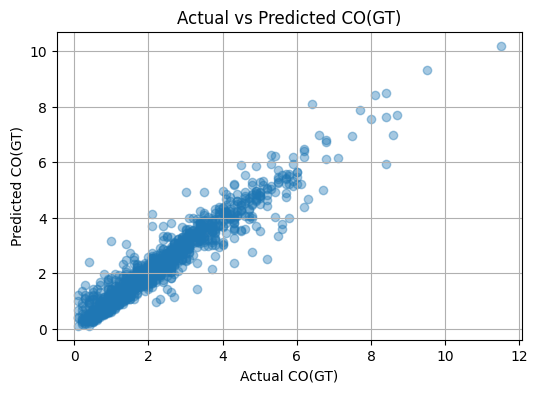

In [11]:
# scatter plot for comparing predictions vs actual values
plt.figure(figsize=(6,4))
plt.scatter(y_test, preds, alpha=0.4)
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Actual vs Predicted CO(GT)")
plt.grid(True)
plt.show()


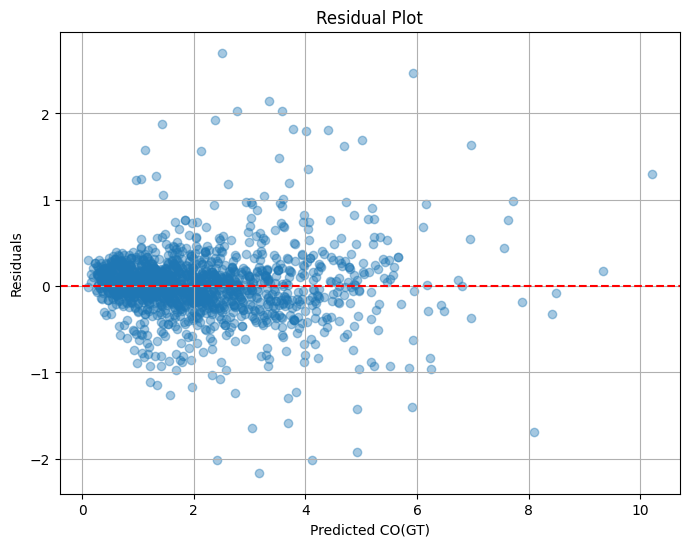

In [12]:
# residuals (errors)
residuals = y_test - preds

# residual plot
plt.figure(figsize=(8,6))
plt.scatter(preds, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted CO(GT)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)
plt.show()

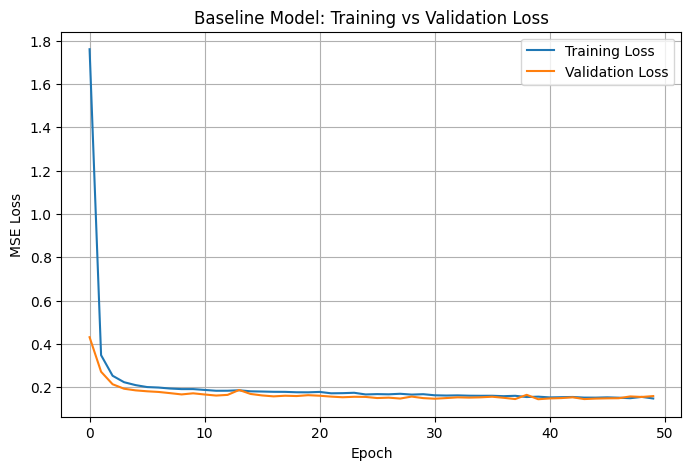

In [19]:
# Training vs Validation Loss for Baseline MLP

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Baseline Model: Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


# Model 2 – Deep Neural Network (DNN) with Dropout + BatchNorm

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# building a deeper neural network
model2 = Sequential()

# first hidden layer
model2.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

# second hidden layer
model2.add(Dense(64, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.2))

# third hidden layer
model2.add(Dense(32, activation='relu'))

# output layer
model2.add(Dense(1))

# compiling the model
model2.compile(optimizer='adam', loss='mse')

# early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# training the model
history2 = model2.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 3.5711 - val_loss: 0.8826
Epoch 2/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5906 - val_loss: 0.3384
Epoch 3/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4953 - val_loss: 0.2126
Epoch 4/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4388 - val_loss: 0.2204
Epoch 5/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4748 - val_loss: 0.1902
Epoch 6/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4097 - val_loss: 0.1975
Epoch 7/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3831 - val_loss: 0.1893
Epoch 8/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4297 - val_loss: 0.1974
Epoch 9/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3459 - val_loss: 0.2183
Epoch 10/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3507 - val_loss: 0.1987
Epoch 11/150
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3505 - val_loss: 0.2119
Epoch 12/150
154/154 ━━━━━━━━━━━━━━━━━━━

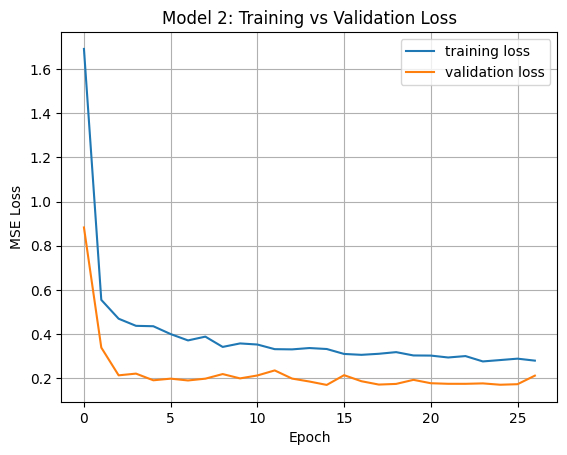

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MODEL 2 PERFORMANCE
MAE: 0.27820506149472163
MSE: 0.18438707628500564
RMSE: 0.18438707628500564
R2 Score: 0.9114748308762912


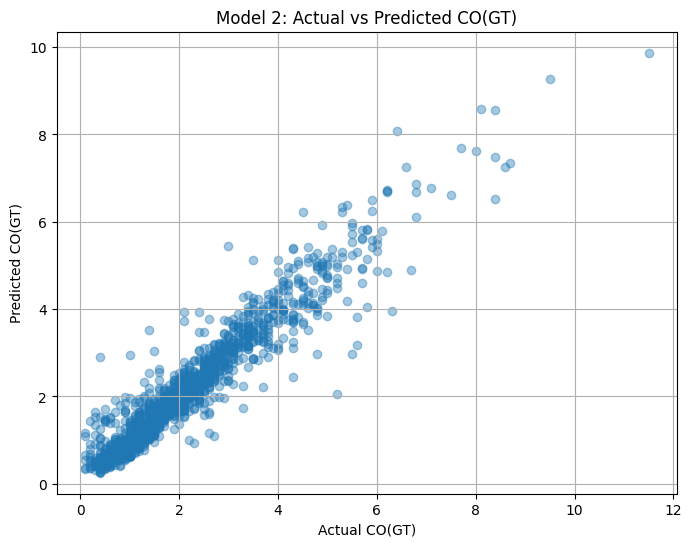

In [16]:
# plotting the training curves
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.title('Model 2: Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# predictions
preds2 = model2.predict(X_test).flatten()

mae2 = mean_absolute_error(y_test, preds2)
mse2 = mean_squared_error(y_test, preds2)
rmse2 = mean_squared_error(y_test, preds2)
r2_2 = r2_score(y_test, preds2)

print("MODEL 2 PERFORMANCE")
print("MAE:", mae2)
print("MSE:", mse2)
print("RMSE:", rmse2)
print("R2 Score:", r2_2)

# scatter plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, preds2, alpha=0.4)
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Model 2: Actual vs Predicted CO(GT)")
plt.grid(True)
plt.show()


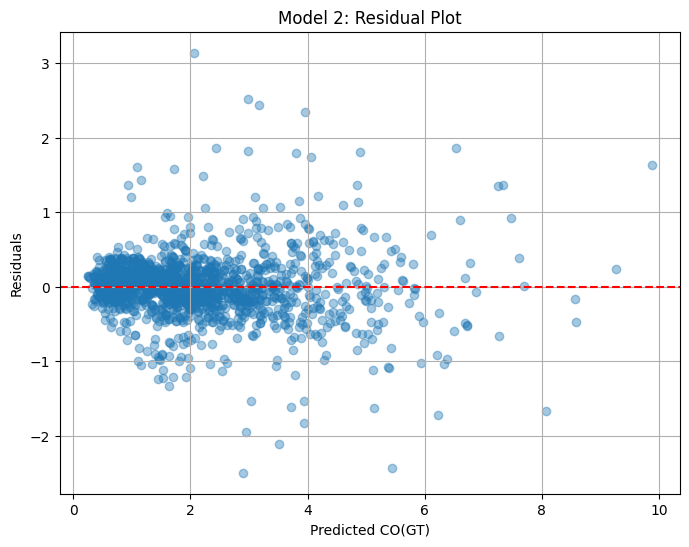

In [17]:
# residuals
res2 = y_test - preds2

plt.figure(figsize=(8,6))
plt.scatter(preds2, res2, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.title("Model 2: Residual Plot")
plt.xlabel("Predicted CO(GT)")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()